In [96]:
!pip install split-folders

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [97]:
import os

def count_subfolders(folder_path):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    subfolder_count = len(subfolders)
    return subfolder_count

folder_path = "/kaggle/input/skin-disease-cancer/Skin_dataset"
subfolder_count = count_subfolders(folder_path)
print(f"Total number of subfolders: {subfolder_count}")


def count_images_in_subfolders(folder_path):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    for subfolder in subfolders:
        image_count = sum(len(files) for _, _, files in os.walk(subfolder) if files)
        subfolder_name = os.path.basename(subfolder)
        print(f"Subfolder: {subfolder_name}, Image count: {image_count}")

folder_path = "/kaggle/input/skin-disease-cancer/Skin_dataset"
count_images_in_subfolders(folder_path)


Total number of subfolders: 2
Subfolder: Malignant_images, Image count: 173
Subfolder: Benign_Images, Image count: 727


### **Importing of Necessary Libraries**

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [99]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [100]:
base_ds = '/kaggle/input/skin-disease-cancer/Skin_dataset'
base_ds = pathlib.Path(base_ds)

In [101]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.1,.2), group_prefix=None)

Copying files: 900 files [00:02, 414.78 files/s]


In [102]:
Benign = [fn for fn in os.listdir(f'{base_ds}/Benign_Images') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Malignant = [fn for fn in os.listdir(f'{base_ds}/Malignant_images') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
# dyed_resection_margins = [fn for fn in os.listdir(f'{base_ds}/dyed-resection-margins') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
# normal_pylorus = [fn for fn in os.listdir(f'{base_ds}/normal-pylorus') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
# normal_cecum = [fn for fn in os.listdir(f'{base_ds}/normal-cecum') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
# polyps = [fn for fn in os.listdir(f'{base_ds}/polyps') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
# ulcerative_colitis = [fn for fn in os.listdir(f'{base_ds}/ulcerative-colitis') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
# esophagitis = [fn for fn in os.listdir(f'{base_ds}/esophagitis') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]


coffee= [Benign,Malignant]
coffee_classes = []
for i in os.listdir('imgs/train'):
    coffee_classes+=[i]
coffee_classes.sort()



### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Total images: 900
Total number of classes: 2
Total Benign_Images images: 727
Total Malignant_images images: 173


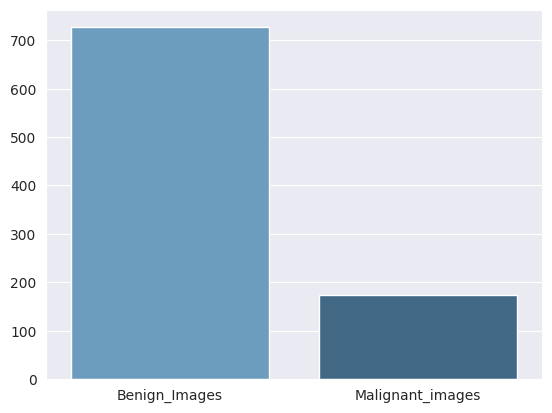

In [103]:
image_count1= len(list(base_ds.glob('*/*.jpg')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count=image_count1+image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
  print(f'Total {x} images: {len(coffee[count])}')
  coffee_count.append(len(coffee[count]))
  count+=1

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (767, 1022, 3)


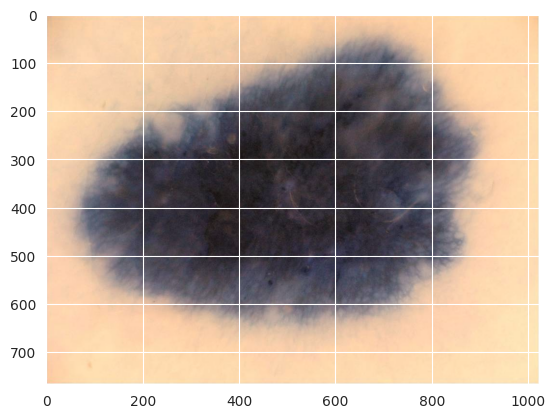

In [104]:
sample_img = cv2.imread('/kaggle/input/skin-disease-cancer/Skin_dataset/Benign_Images/ISIC_0000000.jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [105]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,8, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

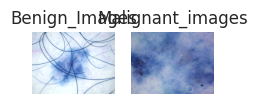

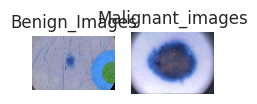

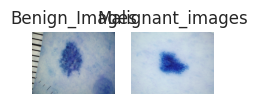

In [106]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [107]:
batch_size =16
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =16,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [108]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [109]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
#     class_mode='binary',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
#     class_mode='binary',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
#     class_mode='binary',
    shuffle=False)

Found 629 images belonging to 2 classes.
Found 89 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [110]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

CONFIG['model_name'] = 'DenseNet121'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='DenseNet121', 
                 job_type='train')

wandb.config.type = 'baseline'

In [111]:
import wandb

# Set your W&B API key
wandb.login(key="8a675fd7c33dab41431d28c4f63fd5e4fb36c19e")

# Define your configuration
CONFIG = {'batch_size': 16, 'img_height': 128, 'img_width': 128, 'model_name': 'Xception'}

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='SkinData',
                 entity="akshitaagarwal2312",
                 config=CONFIG,
                 group='Xception', 
                 job_type='train')

# Set configuration type
wandb.config.type = 'baseline'

print('Training configuration: ', CONFIG)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Training configuration:  {'batch_size': 16, 'img_height': 128, 'img_width': 128, 'model_name': 'Xception'}


## **Transfer Learning**

In [112]:
model=tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
model= tf.keras.Model(inputs, x)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [113]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 2, 2, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 1536)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         3,074 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,339,810 (207.29 MB)

 Trainable params: 54,279,266 (207.06 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [114]:
!pip install --upgrade wandb


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## **Fine Tuning**

In [115]:
# history3 =model.fit(train_ds, epochs =2, validation_data = val_ds,callbacks=[WandbCallback()])
# run.finish()
# history3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[WandbCallback(model=model, save_model=False)])
# run.finish()
history3 =model.fit(train_ds, epochs =35, validation_data = val_ds)
run.finish()


Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.3060 - loss: 0.9559 - val_accuracy: 0.2809 - val_loss: 0.8840
Epoch 2/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.4254 - loss: 0.8091 - val_accuracy: 0.6629 - val_loss: 0.6675
Epoch 3/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.5642 - loss: 0.6721 - val_accuracy: 0.7416 - val_loss: 0.9104
Epoch 4/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6803 - loss: 0.5878 - val_accuracy: 0.7416 - val_loss: 2.5792
Epoch 5/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.7237 - loss: 0.5536 - val_accuracy: 0.7640 - val_loss: 2.2105
Epoch 6/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.7816 - loss: 0.4984 - val_accuracy: 0.7640 - val_loss: 14.7353
Epoch 7/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7644 - loss: 0.4893 - val_accuracy: 0.7528 - val_loss: 23.0752
Epoch 8/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.7909 - loss: 0.4919 - val_accuracy: 0.8202 - val_loss: 

## **Final Evaluation**

In [116]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='SkinData', 
                 config=CONFIG,
                 group='Xception', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 786ms/step - accuracy: 0.9510 - loss: 0.1985


In [117]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.6099221706390381,"
" Accuracy: 81.86812996864319


In [118]:
Y_pred =model.predict(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step 


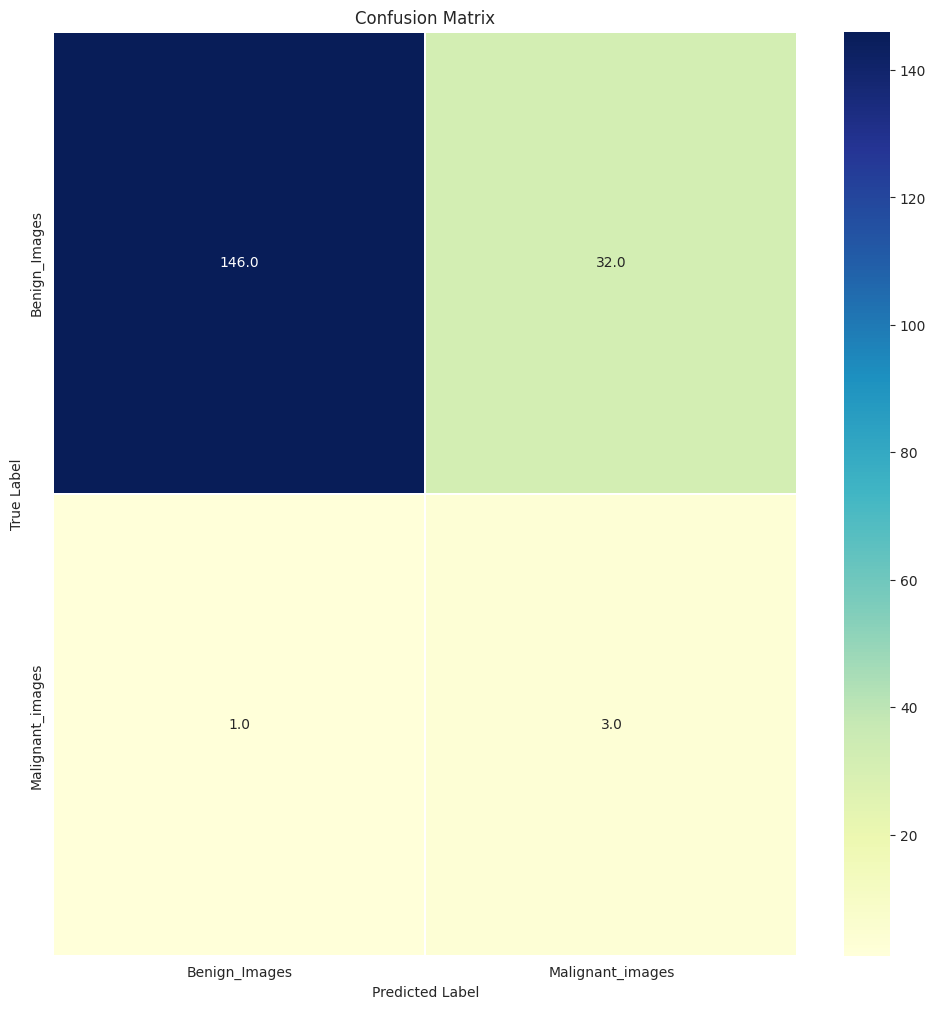

In [119]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [120]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2


,precision,recall,f1-score,support
Benign_Images,0.820225,0.993197,0.898462,147.000000
Malignant_images,0.750000,0.085714,0.153846,35.000000
accuracy,0.818681,0.818681,0.818681,0.818681
macro avg,0.785112,0.539456,0.526154,182.000000
weighted avg,0.806720,0.818681,0.755266,182.000000


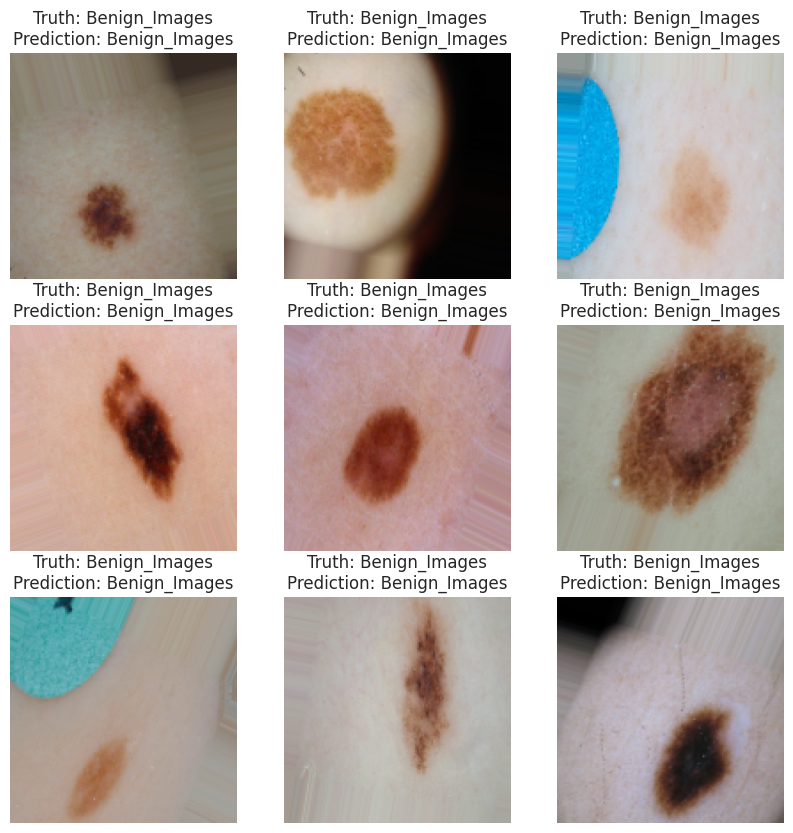

In [121]:
plt.figure(figsize=(10, 10))

# Generate a batch of data
x_batch, label_batch = next(train_ds)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    
    # Find the index of the true class
    result = np.where(label_batch[i] == 1)
    
    # Make a prediction for the image
    predict = model(tf.expand_dims(x_batch[i], 0))
    
    # Get the predicted class label
    score = tf.nn.softmax(predict[0])
    score_label = coffee_classes[np.argmax(score)]
    
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction: {score_label}')
    plt.axis(False)

plt.show()


In [122]:
model.save('Xception-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='SkinData', 
                 config=CONFIG,
                 group='Xception', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='Xception', type='model')
artifact.add_file('Xception-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()



ValueError: Unable to synchronously create dataset (name already exists)

<h2>Support by giving an upvote!!</h2>